## Setup

In [1]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random
# import cudf as pd
import tensorflow as tf
import isuelogit as isl
import glob

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/Library/CloudStorage/OneDrive-Personal/data-science/github/gisuelogit


In [3]:
# Internal modules
from src.aesuelogit.models import UtilityParameters, BPRParameters, ODParameters, GISUELOGIT, NGD
from src.aesuelogit.visualizations import plot_predictive_performance
from src.aesuelogit.networks import load_k_shortest_paths, read_paths, build_fresno_network, \
    Equilibrator, sparsify_OD, ColumnGenerator, read_OD
from src.aesuelogit.etl import get_design_tensor, get_y_tensor, data_curation, temporal_split
from src.aesuelogit.descriptive_statistics import mse, btcg_mse, mnrmse

In [4]:
# Seed for reproducibility
_SEED = 2022
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

## Build Fresno network

In [5]:
fresno_network = build_fresno_network()

## Read OD matrix

In [6]:
read_OD(network=fresno_network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs


## Read paths

In [7]:
# read_paths(network=fresno_network, update_incidence_matrices=True, filename='paths-fresno.csv')
read_paths(network=fresno_network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

# For quick testing
# Q = fresno_network.load_OD(sparsify_OD(fresno_network.Q, prop_od_pairs=0.99))
# load_k_shortest_paths(network=fresno_network, k=2, update_incidence_matrices=True)

18289 paths were read in 18.9[s]              

18289 paths were loaded in the network

Updating incidence matrices

Matrix D (2413, 18289) generated in 17.6[s]               

Matrix M (6970, 18289) generated in 6.9[s]               

Matrix C (18289, 18289) generated in 3.7[s]               



## Read spatiotemporal data

In [8]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*fresno-link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[df['date'].dt.dayofweek.between(0, 4)]
# df = df[df['date'].dt.year == 2019]

df['period'] = df['date'].astype(str) + '-' + df['hour'].astype(str)
df['period'] = df.period.map(hash)

## Data curation

In [9]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

df = data_curation(df)

## Utility function

In [10]:
features_Z = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

utility_parameters = UtilityParameters(features_Y=['tt'],
                                       features_Z=features_Z,
                                       periods = 1,
                                       initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                       'fixed_effect': np.zeros_like(fresno_network.links)},
                                       signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                              'bus_stops': '-', 'intersections': '-'},
                                       trainables={'psc_factor': False, 'fixed_effect': False},
                                       )

utility_parameters.constant_initializer(0)

## Data processing

In [11]:
n_links = len(fresno_network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [12]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix']].describe()

,counts,tt_ff,tt_avg,tf_inrix
count,9704.000000,166497.000000,127290.000000,166497.000000
mean,1880.469281,0.003388,0.003647,0.192740
std,791.369747,0.004391,0.004636,0.224399
min,3.000000,0.000000,0.000000,0.000000
25%,1361.000000,0.000000,0.000000,0.000000
50%,1787.000000,0.002470,0.002667,0.144000
75%,2302.700000,0.004641,0.005429,0.272000
max,4807.000000,0.070339,0.059900,4.605000


In [13]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix']].describe()

,counts,tt_ff,tt_avg,tf_inrix
count,9290.000000,159258.000000,120497.000000,159258.000000
mean,1822.742196,0.003351,0.003463,0.188521
std,795.855464,0.004363,0.004431,0.219121
min,31.000000,0.000000,0.000000,0.000000
25%,1275.125000,0.000000,0.000000,0.000000
50%,1715.000000,0.002429,0.002551,0.142000
75%,2242.750000,0.004539,0.005131,0.263000
max,4798.000000,0.070339,0.058472,3.775000


In [14]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in fresno_network.links:
    fresno_network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==str(link.key)])

## Training and validation sets

In [15]:
df = df.sort_values(by = 'date').copy()

for year in sorted(df['year'].unique()):
    df_year = df[df['year'] == year]

    n_days, n_hours = len(df_year.date.unique()), len(df_year.hour.unique())

    traveltime_data = get_y_tensor(y=df_year[['tt_avg']], n_links=n_links, n_days=n_days, n_hours=n_hours)
    flow_data = get_y_tensor(y=df_year[['counts']], n_links=n_links, n_days=n_days, n_hours=n_hours)

    Y[year] = tf.concat([traveltime_data, flow_data], axis=3)

    X[year] = get_design_tensor(Z=df_year[features_Z], n_links=n_links, n_days=n_days, n_hours=n_hours)

    tt_ff = get_design_tensor(Z=df_year[['tt_ff']], n_links=n_links, n_days=n_days, n_hours=n_hours)

2022-10-04 00:04:07.757939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# We only pick data from one year
X = X[2019]
Y = Y[2019]

# Prepare the training and validation dataset
X, Y = tf.concat(X,axis = 0), tf.concat(Y,axis = 0)
#X_train, X_test, Y_train, Y_test = train_test_split(X.numpy(), Y.numpy(), test_size=0.5, random_state=_SEED)
X_train, X_test, Y_train, Y_test = temporal_split(X.numpy(), Y.numpy(), n_days = 20)
X_train, X_test, Y_train, Y_test = [tf.constant(i) for i in [X_train, X_test, Y_train, Y_test]]

## Network equilibrium predictor

In [17]:
equilibrator = Equilibrator(
    network=fresno_network,
    # paths_generator=paths_generator,
    utility=utility_parameters,
    max_iters=100,
    method='fw',
    iters_fw=50,
    accuracy=1e-4,
)

column_generator = ColumnGenerator(equilibrator=equilibrator,
                                   utility=utility_parameters,
                                   n_paths=0,
                                   ods_coverage=0.1,
                                   ods_sampling='sequential',
                                   # ods_sampling='demand',
                                   )

## Configuration

In [18]:
_EPOCHS = 500
_BATCH_SIZE = 16
_LR = 5e-1
_RELATIVE_GAP = 1e-4
_XTICKS_SPACING = 50
_EPOCHS_PRINT_INTERVAL = 10

## Models

In [19]:
run_model = dict.fromkeys(['equilibrium', 'lue', 'ode', 'odlue', 'odlulpe-1','odlulpe-2', 'tvodlulpe'], False)

run_model['lue'] = True
run_model['odlue'] = True
run_model['odlulpe-1'] = True
run_model['odlulpe-2'] = True



In [20]:
train_losses_dfs = {}
val_losses_dfs = {}

### Model 1: Benchmark of aesuelogit and isuelogit


LUE: Benchmark of aesuelogit and isuelogit (utility only)

Epoch: 0, n_train: 10, n_test: 10

0: train_loss=2.7e+06, val_loss=2.7e+06, train_loss tt=3.8e-05, val_loss tt=3.6e-05, train_loss flow=2.3e+06, val_loss flow=2.3e+06, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, relative x=1.4e-16, relative gap=1e+10, train tt equilibrium loss=4e-36, train flow equilibrium loss=3.1e-26, time:  12.3

Epoch: 10, n_train: 10, n_test: 10

10: train_loss=2.7e+06, val_loss=2.7e+06, train_loss tt=2.8e-05, val_loss tt=2.6e-05, train_loss flow=2.3e+06, val_loss flow=2.3e+06, theta = [-2.0687 -2.1545  0.     -2.0318 -2.0235 -2.0452], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 1.1, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, relative x=0.19, relative gap=0.044, train tt equilibrium loss=1.4e-06, train flow equilibrium loss=1.1e+05, time:  170.1

Epoch: 20, n_train: 10, n_test: 10

20: train_

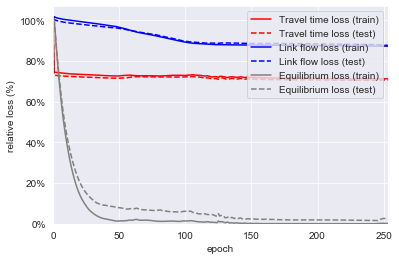

In [21]:
if run_model['lue']:
    print('\nLUE: Benchmark of aesuelogit and isuelogit (utility only)')

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'speed_sd': True, 'median_inc': True, 'incidents': True,
                                                              'bus_stops': True, 'intersections': True
                                                       },
                                           )

    utility_parameters.constant_initializer(0)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values=fresno_network.q.flatten(),
                                 true_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=False)

    equilibrator = Equilibrator(
        network=fresno_network,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       )

    lue = GISUELOGIT(
        key='lue',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator = equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_losses_dfs['lue'], val_losses_dfs['lue'] = lue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_weights={'od': 0, 'theta': 0, 'tt': 1e10, 'flow': 1, 'eq_flow': 1},
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_losses_dfs['lue'], val_losses=val_losses_dfs['lue'],
                                xticks_spacing = _XTICKS_SPACING)


    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}")
    print(f"alpha = {lue.alpha: 0.2f}, beta  = {lue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 2: OD + utility estimation with historic OD


ODLUE: OD + utility estimation with historic OD

Epoch: 0, n_train: 10, n_test: 10

0: train_loss=2.7e+06, val_loss=2.7e+06, train_loss tt=3.8e-05, val_loss tt=3.6e-05, train_loss flow=2.3e+06, val_loss flow=2.3e+06, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, relative x=1.4e-16, relative gap=1e+10, train tt equilibrium loss=4e-36, train flow equilibrium loss=3.1e-26, time:  13.2

Epoch: 10, n_train: 10, n_test: 10

10: train_loss=2e+06, val_loss=2.1e+06, train_loss tt=2.3e-05, val_loss tt=2.2e-05, train_loss flow=1.6e+06, val_loss flow=1.7e+06, theta = [-2.0376 -2.3269  0.     -2.5923 -2.1511 -2.2094], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0.98, avg alpha=0.15, avg beta=4, loss demand=3.2e+02, relative x=0.48, relative gap=0.025, train tt equilibrium loss=3.9e-06, train flow equilibrium loss=1.6e+05, time:  193.3

Epoch: 20, n_train: 10, n_test: 10

20: train_loss=1.6e+0

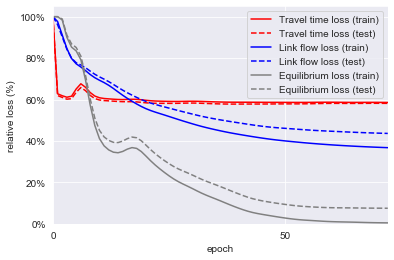

In [22]:
if run_model['odlue']:

    print('\nODLUE: OD + utility estimation with historic OD')

    # _RELATIVE_GAP = 1e-4\
    # _XTICKS_SPACING = 50

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)
    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)
    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'speed_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlue = GISUELOGIT(
        key='odlue',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_losses_dfs['odlue'], val_losses_dfs['odlue'] = odlue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        # generalization_error={'train': False, 'validation': True},
        loss_weights={'od': 1, 'theta': 0, 'tt': 1e10, 'flow': 1, 'eq_flow': 1},
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_losses_dfs['odlue'], val_losses=val_losses_dfs['odlue'],
                                xticks_spacing = _XTICKS_SPACING)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}")
    print(f"alpha = {odlue.alpha: 0.2f}, beta  = {odlue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 3: ODLUE + link specific performance parameters (only alphas)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)

Epoch: 0, n_train: 10, n_test: 10

0: train_loss=2.7e+06, val_loss=2.7e+06, train_loss tt=3.8e-05, val_loss tt=3.6e-05, train_loss flow=2.3e+06, val_loss flow=2.3e+06, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, relative x=1.4e-16, relative gap=1e+10, train tt equilibrium loss=5e-36, train flow equilibrium loss=3.1e-26, time:  12.7

Epoch: 10, n_train: 10, n_test: 10

10: train_loss=1.9e+06, val_loss=2e+06, train_loss tt=2.1e-05, val_loss tt=2e-05, train_loss flow=1.6e+06, val_loss flow=1.7e+06, theta = [-2.0673 -2.3388  0.     -2.5775 -2.1559 -2.2133], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0.98, avg alpha=0.58, avg beta=4, loss demand=3.1e+02, relative x=0.47, relative gap=0.03, train tt equilibrium loss=2.2e-06, train flow equilibrium loss=1.4e+05, time:  189.3

Epoch: 20, n_tra

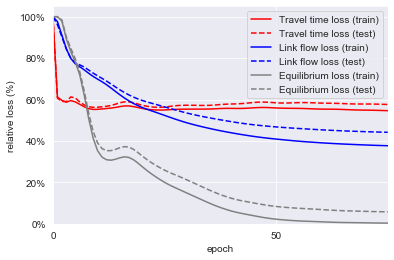

In [23]:
if run_model['odlulpe-1']:

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)')

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _LR = 1e-2
    # _RELATIVE_GAP = 1e-5
    # _XTICKS_SPACING = 50

    # Some initializations of the bpr parameters, makes the optimization to fail (e.g. alpha =1, beta = 1). Using a common
    # alpha but different betas for every link make the estimation more stable but there is overfitting after a certain amount of iterations

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   # initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                   #                 'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15,
                                   #                 'beta': 4 * np.ones_like(fresno_network.links, dtype=np.float32)},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta':False},
                                   # trainables={'alpha': True, 'beta': True},
                                   # trainables={'alpha': False, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'psc_factor': 0, 'tt':0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'speed_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlulpe_1 = GISUELOGIT(
        key='odlulpe-1',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_losses_dfs['odlulpe-1'], val_losses_dfs['odlulpe-1'] = odlulpe_1.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        # loss_weights={'od': 1, 'theta': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1},
        loss_weights={'od': 1, 'theta': 0, 'tt': 1e10, 'flow': 1, 'eq_flow': 1},
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        # loss_metric=mnrmse,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_losses_dfs['odlulpe-1'], val_losses=val_losses_dfs['odlulpe-1'],
                                xticks_spacing = _XTICKS_SPACING)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_1.theta.numpy())))}")
    print(f"alpha = {np.mean(odlulpe_1.alpha): 0.2f}, beta  = {np.mean(odlulpe_1.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_1.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 4: ODLUE + link specific performance parameters (alphas and betas)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)

Epoch: 0, n_train: 10, n_test: 10

0: train_loss=2.7e+06, val_loss=2.7e+06, train_loss tt=3.8e-05, val_loss tt=3.6e-05, train_loss flow=2.3e+06, val_loss flow=2.3e+06, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, relative x=1.4e-16, relative gap=1e+10, train tt equilibrium loss=4.9e-36, train flow equilibrium loss=3.1e-26, time:  13.0

Epoch: 10, n_train: 10, n_test: 10

10: train_loss=1.9e+06, val_loss=2e+06, train_loss tt=1.9e-05, val_loss tt=1.8e-05, train_loss flow=1.6e+06, val_loss flow=1.7e+06, theta = [-2.0902 -2.3339  0.     -2.559  -2.1553 -2.208 ], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0.98, avg alpha=0.58, avg beta=2.4, loss demand=3.2e+02, relative x=0.48, relative gap=0.029, train tt equilibrium loss=1.6e-06, train flow equilibrium loss=1.5e+05, time:  187.9

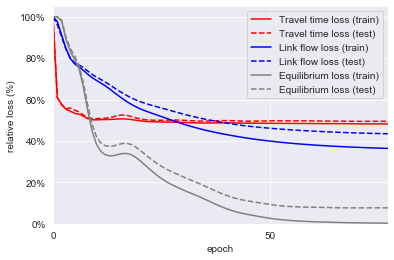

In [24]:
if run_model['odlulpe-2']:

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)')

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _LR = 5e-1
    # _RELATIVE_GAP = 1e-5

    # Some initializations of the bpr parameters, makes the optimization to fail (e.g. alpha =1, beta = 1). Using a common
    # alpha but different betas for every link make the estimation more stable but there is overfitting after a certain amount of iterations

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   # initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                   #                 'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15,
                                   #                 'beta': 4 * np.ones_like(fresno_network.links, dtype=np.float32)},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # trainables={'alpha': True, 'beta':False},
                                   trainables={'alpha': True, 'beta': True},
                                   # trainables={'alpha': False, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'psc_factor': 0, 'tt':0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'speed_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlulpe_2 = GISUELOGIT(
        key='odlulpe_2',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_losses_dfs['odlulpe_2'], val_losses_dfs['odlulpe_2'] = odlulpe_2.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        # loss_weights={'od': 1, 'theta': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1},
        loss_weights={'od': 1, 'theta': 0, 'tt': 1e10, 'flow': 1, 'eq_flow': 1},
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        # loss_metric=mnrmse,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_losses_dfs['odlulpe_2'], val_losses=val_losses_dfs['odlulpe_2'],
                                xticks_spacing = _XTICKS_SPACING)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_2.theta.numpy())))}")
    print(f"alpha = {np.mean(odlulpe_2.alpha): 0.2f}, beta  = {np.mean(odlulpe_2.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_2.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")